Original Dataset Shape: (1585, 30)


,time,tavg,tmin,tmax,prcp,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,...,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,2009-01-01,20.5,14.3,29.0,NaN,2009-01-01,27,12,0.0,11.6,...,18,11,2,91,0.0,1014,14,10,109,8
1,2009-02-01,20.0,15.8,NaN,NaN,2009-02-01,32,14,0.0,11.6,...,18,18,6,72,0.0,1013,17,10,111,9
2,2009-03-01,20.5,15.3,27.4,NaN,2009-03-01,36,17,0.0,11.6,...,22,15,0,32,0.0,1011,19,10,151,7
3,2009-04-01,19.9,15.0,27.4,NaN,2009-04-01,36,19,0.0,11.6,...,25,8,1,51,0.0,1009,21,10,160,6
4,2009-05-01,19.9,14.7,26.4,NaN,2009-05-01,38,23,0.0,12.8,...,26,13,18,68,0.2,1010,25,9,255,10



Missing Values Before Handling:
time                   0
tavg                   0
tmin                  48
tmax                   6
prcp                 895
date_time              0
maxtempC               0
mintempC               0
totalSnow_cm           0
sunHour                0
uvIndex                0
uvIndex.1              0
moon_illumination      0
moonrise               0
moonset                0
sunrise                0
sunset                 0
DewPointC              0
FeelsLikeC             0
HeatIndexC             0
WindChillC             0
WindGustKmph           0
cloudcover             0
humidity               0
precipMM               0
pressure               0
tempC                  0
visibility             0
winddirDegree          0
windspeedKmph          0
dtype: int64

Explained Variance by PCA Components:
[0.36223828 0.33017174]


<ipython-input-1-d829898b0e55>:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['prcp'].fillna(0, inplace=True)
<ipython-input-1-d829898b0e55>:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({

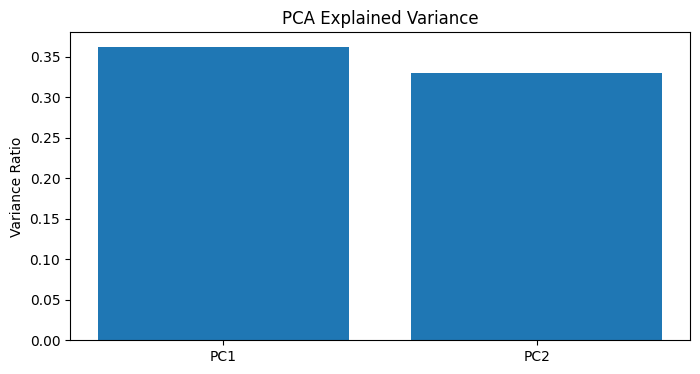

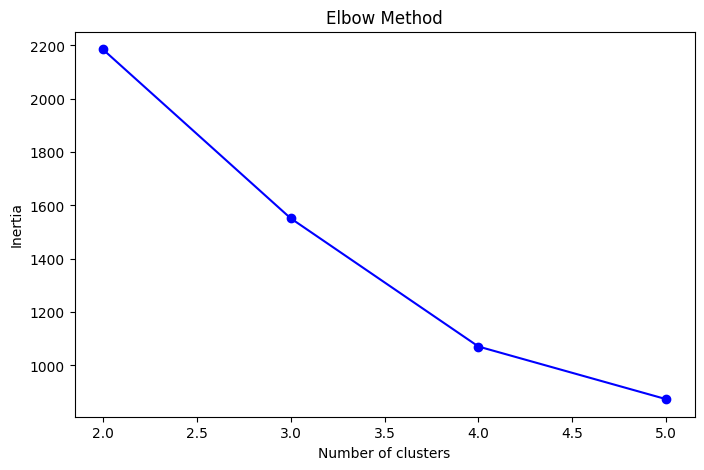


Risk Zone Distribution:


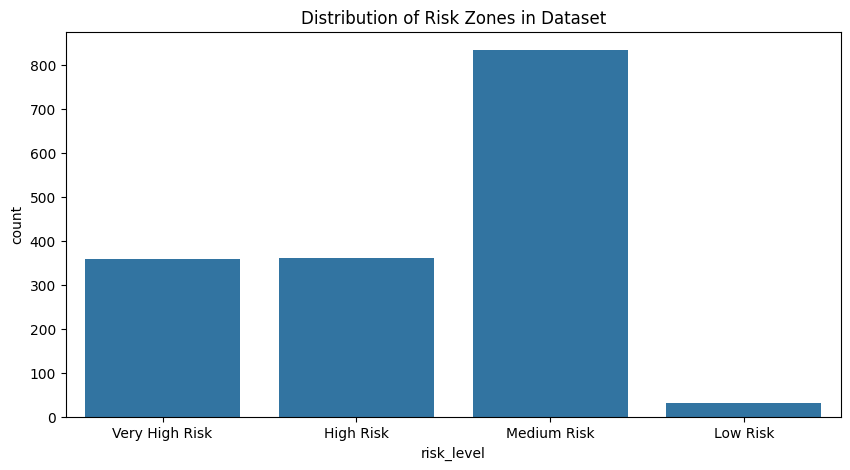

✅ Model, scaler, and PCA saved successfully.


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import ipywidgets as widgets
from IPython.display import display

# Load and preprocess data
df = pd.read_csv('/content/merged_bengaluru_dataset.csv')

print("Original Dataset Shape:", df.shape)
display(df.head())

print("\nMissing Values Before Handling:")
print(df.isnull().sum())

# Handle missing values
df['prcp'].fillna(0, inplace=True)
df['precipMM'].fillna(0, inplace=True)

temp_cols = ['tavg']
for col in temp_cols:
    df[col].fillna(df['tavg'].mean(), inplace=True)

# Create new feature for total precipitation
df['total_precip'] = df['prcp'] + df['precipMM']

# Select final features
features = ['total_precip', 'tavg', 'humidity']
X = df[features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 components
X_pca = pca.fit_transform(X_scaled)

print("\nExplained Variance by PCA Components:")
print(pca.explained_variance_ratio_)

# Visualize PCA explained variance
plt.figure(figsize=(8,4))
plt.bar(range(1, 3), pca.explained_variance_ratio_, tick_label=['PC1', 'PC2'])
plt.title('PCA Explained Variance')
plt.ylabel('Variance Ratio')
plt.show()

# Determine optimal number of clusters using Elbow Method
inertia = []
K_range = range(2, 6)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

# Train final K-Means model (using 4 clusters now)
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(X_pca)
df['risk_zone'] = clusters

# Interpret clusters and assign risk levels
cluster_stats = df.groupby('risk_zone')[features].mean().sort_values('total_precip')

# Updated 4 risk levels
risk_levels = ['Very High Risk', 'High Risk', 'Medium Risk', 'Low Risk']
risk_mapping = {cluster_stats.index[i]: risk_levels[i] for i in range(optimal_clusters)}
df['risk_level'] = df['risk_zone'].map(risk_mapping)

# Solutions per risk zone
def get_risk_zone_solutions(risk_level):
    solutions = {
        'Very High Risk': {
            'Water Conservation': [
                "Mandatory rainwater harvesting",
                "Strict water rationing",
                "High subsidies for efficient irrigation"
            ],
            'Infrastructure': [
                "Build multiple check dams",
                "Aggressive aquifer recharge programs"
            ],
            'Policy': [
                "Water extraction limits",
                "Heavy penalties for overuse"
            ]
        },
        'High Risk': {
            'Water Management': [
                "Rainwater harvesting incentives",
                "Smart irrigation promotion"
            ],
            'Infrastructure': [
                "Groundwater monitoring expansion",
                "Greywater recycling systems"
            ]
        },
        'Medium Risk': {
            'Prevention': [
                "Awareness drives on water conservation",
                "Minor infrastructure upgrades"
            ],
            'Planning': [
                "Future water demand modeling",
                "Monitoring recharge patterns"
            ]
        },
        'Low Risk': {
            'Maintenance': [
                "Regular checks on groundwater quality",
                "Protection of recharge areas"
            ],
            'Planning': [
                "Sustainability audits",
                "Long-term conservation planning"
            ]
        }
    }
    return solutions.get(risk_level, {})

# Plot recommended solutions
def plot_risk_zone_solutions(risk_level):
    solutions = get_risk_zone_solutions(risk_level)

    if not solutions:
        print(f"No solutions defined for {risk_level} zone")
        return

    plt.figure(figsize=(12, 6))
    plt.suptitle(f"{risk_level} Zone Recommended Solutions", fontsize=16, y=1.05)

    for i, (category, measures) in enumerate(solutions.items()):
        plt.subplot(1, len(solutions), i+1)
        plt.title(category)
        plt.barh(range(len(measures)), [1]*len(measures), color=plt.cm.tab20(i))
        plt.yticks(range(len(measures)), measures)
        plt.gca().invert_yaxis()
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Predict and display solutions
def predict_and_display(precip, temp, humidity):
    input_data = np.array([[precip, temp, humidity]])
    input_scaled = scaler.transform(input_data)
    input_pca = pca.transform(input_scaled)
    cluster = kmeans.predict(input_pca)[0]
    risk_level = risk_mapping[cluster]

    print(f"\n{'='*50}")
    print(f"Predicted Risk Zone: {risk_level}")
    print(f"{'='*50}\n")

    zone_stats = cluster_stats.loc[cluster_stats.index[cluster]]
    print("Zone Characteristics:")
    print(f"- Average Precipitation: {zone_stats['total_precip']:.2f} mm")
    print(f"- Average Temperature: {zone_stats['tavg']:.2f} °C")
    print(f"- Average Humidity: {zone_stats['humidity']:.2f} %\n")

    plot_risk_zone_solutions(risk_level)

    solutions = get_risk_zone_solutions(risk_level)
    print("\nRecommended Action Plan:")
    for category, measures in solutions.items():
        print(f"\n{category}:")
        for i, measure in enumerate(measures, 1):
            print(f"  {i}. {measure}")

# Create interactive widgets
precip_slider = widgets.FloatSlider(
    value=df['total_precip'].median(),
    min=df['total_precip'].min(),
    max=df['total_precip'].max(),
    step=0.1,
    description='Precip (mm):',
    continuous_update=False
)

temp_slider = widgets.FloatSlider(
    value=df['tavg'].median(),
    min=df['tavg'].min(),
    max=df['tavg'].max(),
    step=0.1,
    description='Temp (°C):',
    continuous_update=False
)

humid_slider = widgets.FloatSlider(
    value=df['humidity'].median(),
    min=df['humidity'].min(),
    max=df['humidity'].max(),
    step=0.1,
    description='Humidity (%):',
    continuous_update=False
)

predict_button = widgets.Button(description="Predict Risk Zone")
output = widgets.Output()

def on_button_click(b):
    with output:
        output.clear_output()
        predict_and_display(
            precip_slider.value,
            temp_slider.value,
            humid_slider.value
        )

predict_button.on_click(on_button_click)

# Display widgets
display(widgets.VBox([
    widgets.HBox([precip_slider, temp_slider, humid_slider]),
    predict_button,
    output
]))

# Visualize risk zone distribution
print("\nRisk Zone Distribution:")
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='risk_level', order=risk_levels)
plt.title('Distribution of Risk Zones in Dataset')
plt.show()

# Save models
joblib.dump(kmeans, 'groundwater_kmeans_model.pkl')
joblib.dump(scaler, 'groundwater_scaler.pkl')
joblib.dump(pca, 'groundwater_pca.pkl')
print("✅ Model, scaler, and PCA saved successfully.")


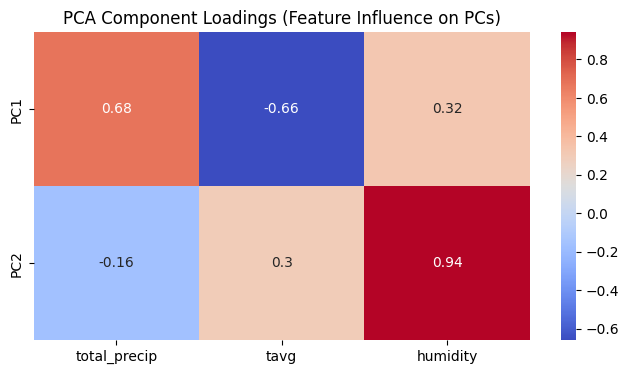


Clustering Evaluation Metrics:
Explained Variance Ratio (PCA): [0.36223828 0.33017174]

⚠️ True labels not available. Skipping confusion matrix and classification metrics.


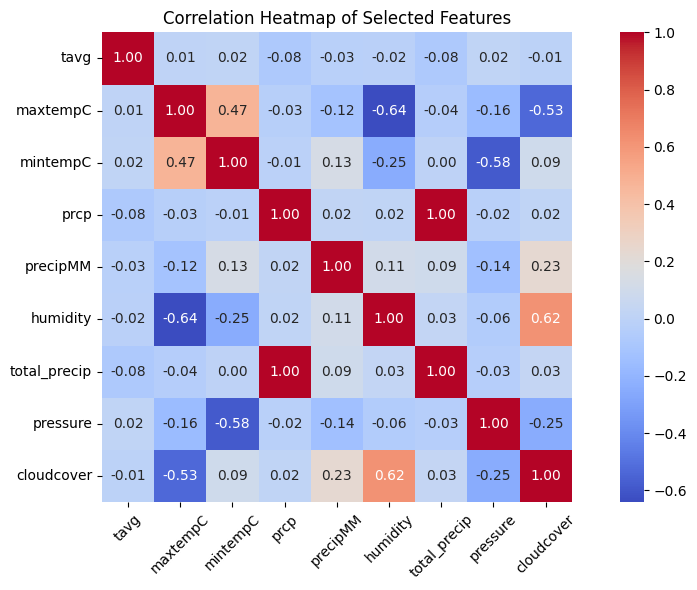

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, silhouette_score, calinski_harabasz_score

# ========================== #
# 1. PCA COMPONENTS HEATMAP
# ========================== #
pca_components = pd.DataFrame(
    pca.components_,
    columns=features,
    index=[f'PC{i+1}' for i in range(pca.n_components_)]
)

plt.figure(figsize=(8, 4))
sns.heatmap(pca_components, annot=True, cmap='coolwarm')
plt.title('PCA Component Loadings (Feature Influence on PCs)')
plt.show()

# ========================== #
# 2. CLUSTERING METRICS
# ========================== #
print("\nClustering Evaluation Metrics:")

# Variance ratio from PCA
print(f"Explained Variance Ratio (PCA): {pca.explained_variance_ratio_}")


# ========================== #
# 3. OPTIONAL: CONFUSION MATRIX, PRECISION, RECALL
# Only if you have true labels like df['true_label']
# ========================== #
if 'true_label' in df.columns:
    print("\nConfusion Matrix and Classification Metrics:")

    # Ensure same order of labels for mapping
    from sklearn.metrics import classification_report

    y_true = df['true_label']
    y_pred = df['risk_zone']  # Cluster labels

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted Cluster")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # Precision, Recall, etc.
    print(classification_report(y_true, y_pred))

else:
    print("\n⚠️ True labels not available. Skipping confusion matrix and classification metrics.")



# =============================== #
# CLEAN HEATMAP OF SELECTED IMPORTANT FEATURES
# =============================== #
important_features = [
    'tavg', 'maxtempC', 'mintempC', 'prcp', 'precipMM',
    'humidity', 'total_precip', 'pressure', 'cloudcover'
]

plt.figure(figsize=(10, 6))
sns.heatmap(df[important_features].corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap of Selected Features')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

